In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from torch.utils.data import Dataset, DataLoader

np.random.seed(1234)

In [2]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

NVIDIA GeForce GTX 1650
Using device: cuda


In [118]:
class BeamData(Dataset):
    def __init__(self, beam_configs=None):
        

        self.data = []

        for config in beam_configs:
            x1 = torch.zeros(10)
            x2 = torch.ones(10)
            x3 = torch.rand(100)
            x4 = torch.hstack((x1, x2, x3))
            x4 = torch.sort(x4)[0].view(-1, 1)
            lbc = torch.tensor(config['lbc'], dtype=torch.float).repeat(120, 1)
            rbc = torch.tensor(config['rbc'], dtype=torch.float).repeat(120, 1)

            self.data.append(torch.cat((x4, lbc, rbc), dim=1))

        self.data = torch.cat(self.data, dim=0).requires_grad_().to(device)

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        sample = self.data[index]
        return sample

In [119]:
def create_test(config):
    """ {x: Amount of pints, lbc: left condition, rbc: right condition} """

    x = torch.linspace(0, 1, config['x']).view(-1, 1)
    lbc = torch.tensor(config['lbc'], dtype=torch.float).repeat(config['x'], 1)
    rbc = torch.tensor(config['rbc'], dtype=torch.float).repeat(config['x'], 1)

    data = torch.cat((x, lbc, rbc), dim=1).to(device)

    return data

In [120]:
def boundary_condition(mask, data, u, u_x, m, m_x):
    loss = nn.MSELoss()

    bc_data = data[mask, 1:]
    bc_mask = bc_data.bool()
    u_bc, u_x_bc, m_bc, m_x_bc = u[mask], u_x[mask], m[mask], m_x[mask]
    
    bc_fixed = loss(u_bc[bc_mask[:, 0]], torch.ones_like(u_bc[bc_mask[:, 0]]))
    bc_fixed += loss(u_x_bc[bc_mask[:, 0]], torch.ones_like(u_x_bc[bc_mask[:, 0]]))

    bc_pinned = loss(u_bc[bc_mask[:, 1]], torch.ones_like(u_bc[bc_mask[:, 1]]))
    bc_pinned += loss(m_bc[bc_mask[:, 1]], torch.ones_like(m_bc[bc_mask[:, 1]]))

    bc_free = loss(m_bc[bc_mask[:, 2]], torch.ones_like(m_bc[bc_mask[:, 2]]))
    bc_free += loss(m_x_bc[bc_mask[:, 2]], torch.ones_like(m_x_bc[bc_mask[:, 2]]))

    total_loss = bc_fixed + bc_pinned + bc_free
    return total_loss

In [121]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [ ]:
class PINN():
    def __init__(self, dataloader, layers):

        self.dataloader = dataloader
        self.dnn = DNN(layers).to(device)

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=0.005)

    def model_value(self, data):
        out = self.dnn(data)
        u = out[:, 0:1]
        m = out[:, 1:2]
        return u, m

    def boundary_condition(self, mask, data, u, u_x, m, m_x, left=True):

        if left:
            bc_data = data[mask, 1:4]
        else:
            bc_data = data[mask, 4:7]
        bc_mask = bc_data.bool()

        u_bc, u_x_bc, m_bc, m_x_bc = u[mask], u_x[mask], m[mask], m_x[mask]
        # Initialize losses
        bc_fixed_loss = torch.tensor(0.0, device=device)
        bc_pinned_loss = torch.tensor(0.0, device=device)
        bc_free_loss = torch.tensor(0.0, device=device)

        # Fixed BC
        if True in bc_mask[:, 0]:
            bc_fixed_loss = torch.mean(torch.pow(u_bc[bc_mask[:, 0]], 2))
            bc_fixed_loss += torch.mean(torch.pow(u_x_bc[bc_mask[:, 0]], 2))

        # Pinned BC
        if True in bc_mask[:, 1]:
            bc_pinned_loss = torch.mean(torch.pow(u_bc[bc_mask[:, 1]], 2))
            bc_pinned_loss += torch.mean(torch.pow(m_bc[bc_mask[:, 1]], 2))

        # Free BC
        if True in bc_mask[:, 2]:
            bc_free_loss = torch.mean(torch.pow(m_bc[bc_mask[:, 2]], 2))
            bc_free_loss += torch.mean(torch.pow(m_x_bc[bc_mask[:, 2]], 2))

        total_loss = bc_fixed_loss + bc_pinned_loss + bc_free_loss
        return total_loss


    def loss_func(self, data):
        u, m = self.model_value(data)

        mask_left = (data[:, 0] == 0)
        mask_right = (data[:, 0] == 1)

        u_x = torch.autograd.grad(u, data, torch.ones_like(u), create_graph=True, retain_graph=True)[0][:, 0:1]
        u_2x = torch.autograd.grad(u_x, data, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]

        m_x = torch.autograd.grad(m, data, torch.ones_like(m), create_graph=True, retain_graph=True)[0][:, 0:1]
        m_2x = torch.autograd.grad(m_x, data, torch.ones_like(m_x), create_graph=True)[0][:, 0:1]

        if True in mask_left:
            bc_left_loss = self.boundary_condition(mask_left, data, u, u_x, m, m_x)
        else:
            bc_left_loss = torch.zeros(1, device=device)

        if True in mask_right:
            bc_right_loss = self.boundary_condition(mask_right, data, u, u_x, m, m_x, False)
        else:
            bc_right_loss = torch.zeros(1, device=device)

        pde_loss = torch.mean(torch.pow(m_2x + 1, 2))
        pde_loss += torch.mean(torch.pow(u_2x + m, 2))


        return pde_loss, bc_left_loss, bc_right_loss
        


    def train(self, epochs=1000):
        self.dnn.train()

        for epoch in range(epochs):
            total_loss = 0
            for data_batch in self.dataloader:
                pde_loss, bc_left_loss, bc_right_loss = self.loss_func(data_batch)
                loss = pde_loss + bc_left_loss + bc_right_loss
                
                self.optimizer_adam.zero_grad()
                loss.backward()
                self.optimizer_adam.step()
                total_loss += loss.item()

            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss = {total_loss:.6f}")
                

In [178]:
p = 100
x = torch.linspace(0, 1, p).view(-1, 1)
# x = torch.tensor([0, 0, 1, 1]).view(-1, 1)

p_d = 100
p_bc = 20
x_l = np.zeros(p_bc)
x_r = np.ones(p_bc)


fixed = [1, 0, 0]
pinned = [0, 1, 0]
free = [0, 0, 1]

nodes = 64
layers = [7] + 4*[nodes] + [2]

beam_configs = [
    {'x': x, 'lbc': fixed, 'rbc': free}, 
    {'x': x, 'lbc': pinned, 'rbc': fixed},
    {'x': x, 'lbc': pinned, 'rbc': pinned},
    {'x': x, 'lbc': fixed, 'rbc': pinned},
    {'x': x, 'lbc': fixed, 'rbc': fixed},
    {'x': x, 'lbc': free, 'rbc': fixed},
]


data = BeamData(beam_configs)
dataloader = DataLoader(data, batch_size=144, shuffle=True)
print(dataloader.dataset.data.shape)
print(layers)

torch.Size([720, 7])
[7, 64, 64, 64, 64, 2]


In [179]:
model = PINN(dataloader, layers)

In [180]:

model.train(1000)

Epoch 0: Loss = 6.424831
Epoch 10: Loss = 0.829872
Epoch 20: Loss = 0.372923
Epoch 30: Loss = 0.202068
Epoch 40: Loss = 0.095144
Epoch 50: Loss = 0.022509
Epoch 60: Loss = 0.007156
Epoch 70: Loss = 0.004223
Epoch 80: Loss = 0.004652
Epoch 90: Loss = 0.004034
Epoch 100: Loss = 0.045581
Epoch 110: Loss = 0.003583
Epoch 120: Loss = 0.001786
Epoch 130: Loss = 0.001535
Epoch 140: Loss = 0.001308
Epoch 150: Loss = 0.001304
Epoch 160: Loss = 0.001149
Epoch 170: Loss = 0.001099
Epoch 180: Loss = 0.001442
Epoch 190: Loss = 0.000918
Epoch 200: Loss = 0.000903
Epoch 210: Loss = 0.000868
Epoch 220: Loss = 0.000833
Epoch 230: Loss = 0.003752
Epoch 240: Loss = 0.015445
Epoch 250: Loss = 0.012905
Epoch 260: Loss = 0.004853
Epoch 270: Loss = 0.005563
Epoch 280: Loss = 0.000934
Epoch 290: Loss = 0.001403
Epoch 300: Loss = 0.000732
Epoch 310: Loss = 0.000842
Epoch 320: Loss = 0.004864
Epoch 330: Loss = 0.017763
Epoch 340: Loss = 0.004783
Epoch 350: Loss = 0.001716
Epoch 360: Loss = 0.001745
Epoch 370: L

KeyboardInterrupt: 

In [181]:
E = 70e9
I = 0.1**4 / 12 # Square cross section with lenght 0.1m
EI = E * I
print(EI)
L = 2.0
Q = -20000.0

583333.3333333335


In [158]:
q1 = lambda x: Q / (24*EI) * (x**4 - 4*L*x**3 + 6*L**2*x**2) # Fixed, free, constant q
q4 = lambda x: Q / (24*EI) * (x**4 - 2*x**3*L + x*L**3) # Pinned, pinned, constant q

In [194]:
n = 100
lc = fixed
rc = fixed

config = {'x': 100, 'lbc': lc, 'rbc': rc}

beam = create_test(config)
print(beam.shape)

torch.Size([100, 7])


In [195]:
u, m = model.model_value(beam)
xp = beam[:, 0:1].detach().cpu().numpy()
x1 = xp * L
u_pred = (L**4 * Q / EI) * u
yp = u_pred.detach().cpu().numpy()
print(yp.shape)
print(xp.shape)

(100, 1)
(100, 1)


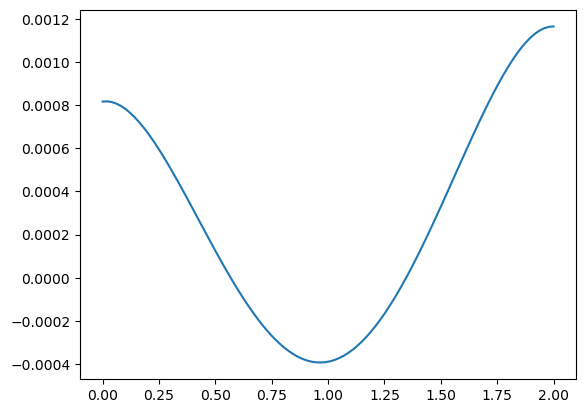

In [196]:
plt.plot(x1, yp)
plt.show()

In [46]:
test = [[0.0, 0, 1, 0, 0, 1, 0],
        [0.0, 0, 1, 0, 0, 1, 0],
        [1.0, 0, 1, 0, 0, 1, 0],
        [1.0, 0, 1, 0, 0, 1, 0]
        ]

test_t = torch.tensor(test, dtype=torch.float, device=device, requires_grad=True)
print(test_t)

tensor([[0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0.]], device='cuda:0', requires_grad=True)


In [47]:
u, m = model.model_value(test_t)
print(u)

pde, left, right = model.loss_func(test_t)

print(pde, left, right)

tensor([[-2.5735e-04],
        [-2.5735e-04],
        [-3.0106e-05],
        [-3.0106e-05]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0138e-06, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0926e-06, device='cuda:0', grad_fn=<AddBackward0>)


In [114]:
x1 = torch.zeros(5)
x2 = torch.ones(5)
x3 = torch.rand(10)
x4 = torch.hstack((x1, x2, x3))
x4 = torch.sort(x4)[0].view(-1, 1)

print(x4)


tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.2107],
        [0.2190],
        [0.3388],
        [0.3532],
        [0.4170],
        [0.5304],
        [0.5631],
        [0.6166],
        [0.7162],
        [0.7348],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])
